In [531]:
#!pip install pmagpy
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pandas as pd
import scipy as sci
from scipy import interpolate
import seaborn as sns

## User Inputs

In [532]:
Exposure_Age_Inputs = pd.read_excel('/Users/mmijjum/Desktop/Exposure_Age_Inputs.xlsx') #excel sheet with all pmag data. 0-70 Ma, all criteria
#Exposure_Age_Inputs

In [533]:
pTRM = False #Does the user want only data that was acquired by Thellier-style methods w/ pTRM checks? Used in paleomag section (DEFAULT: False)
QPI = False #Does the user want to filter by data quality (QPI >= 3)? Used in Paleomag section (DEFAULT: False)

sample_names = Exposure_Age_Inputs['Sample Name']
site_lat = Exposure_Age_Inputs['Latitude']
site_lon = Exposure_Age_Inputs['Longitude'] #correct for negative longitudes in ERA40 analysis
altitude = Exposure_Age_Inputs['Elevation'] #user input, in meters above sea level, for pressure correction. Used in pressure section
sample_thickness = Exposure_Age_Inputs['Sample Thickness']
sample_density = Exposure_Age_Inputs['Sample Density']
shielding = Exposure_Age_Inputs['Shielding Correction']
Nuclide = Exposure_Age_Inputs['Nuclide']
Mineral = Exposure_Age_Inputs['Mineral']
nuclide_concentration = Exposure_Age_Inputs['Nuclide Concentration']
nuclide_concentration_uncertainty = Exposure_Age_Inputs['Latitude']
stdatm = 1 #user inputs 1 for standard, 0 for ERA40. Used in pressure section
w = 0.06; # water content, from 0-1. Used in production rates calculation. 0.06 is standard, see LSD.
SLHL = 119.598 #at/g/yr
system = 3
system_b = 0 #1 = enstatite, 2 = ferrosilite, 3 = wollastonite, 4 = augite. Put 0 if using qtz or ol
system_c = 1 #1 = forsterite, 2 = fayalite, 3 = f8?. Put 0 if using qtz or cpx


## Paleointensity Section
- Cell 1: import custom paleomag (IAGA + Geomagia) database. Need excel file for this to run. Compiled by Katie Bristol
- Cell 2: generates paleolatitude (variational) vector
- Cell 3: Code will drop any data points beyond 70 Ma.
    - This cell also includes any criteria specifications
    - NOTE: if you change therm from true to false, have to run notebook from beginning. 
- Cell 5: assigns bin_names in 5 myr increments to the dataset. 
- Cell 6: calculates mean VDM's for each 5 Myr bin, while also printing out how many datapoints were used to calculate this mean.

In [534]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [536]:
from datetime import date
todays_date = date.today()

#Importing data from databases - MAY BE ISSUE WITH VADM (GEOMAGIA) and VDM (PINT)
#Could solve by just converting average VADM value to vDM maybe 

# GEOMAGIA data (https://urldefense.proofpoint.com/v2/url?u=https-3A__geomagia.gfz-2Dpotsdam.de_geomagiav3_AAquery.php-29-255Cn&d=DwIGAg&c=sJ6xIWYx-zLMB3EPkvcnVg&r=-ISFeLc9OBPOASaQVb68asJMg_-3XpxVSS4K_An0R8o&m=RwLLbQoWdit5wbgAfI8DQSd3QHw94dgEpz-ZLCiNYsMgnp9m1Mf7N4p439pfQvUN&s=2hubuu3mlf70aGi8WuTGuOnkNLz8HP6e1Q1py46c-EE&e= #Query settings: Intensities, VADM, I, All material types, No dating constraints, No geographic constraints
#Download: Figures & Downloads tab -> "Click here to download the results as a .csv file."
GEOMAGIA_db = pd.read_csv('archeo005.csv', skiprows=1)
GEOMAGIA_db['Age[yr]'] = -(GEOMAGIA_db['Age[yr.AD]'] - todays_date.year) * 1*10**-6 # Converts ages from AD to Mya 

# PINT data (https://urldefense.proofpoint.com/v2/url?u=http-3A__www.pintdb.org_Database-29-255Cn&d=DwIGAg&c=sJ6xIWYx-zLMB3EPkvcnVg&r=-ISFeLc9OBPOASaQVb68asJMg_-3XpxVSS4K_An0R8o&m=RwLLbQoWdit5wbgAfI8DQSd3QHw94dgEpz-ZLCiNYsMgnp9m1Mf7N4p439pfQvUN&s=RTKfq5ej9Jm_T_2NGpIJSsRStX1cZ_tZ3-J9HHDpgwA&e= #Download: Entire Excel spreadsheet ("definitive version of the PINT database") from the Database tab
PINT_db = pd.read_excel('S1_PINT_QPI.xlsx')
PINT_db = PINT_db.loc[PINT_db.AGE <= 70] #Filters by age to only include 0 - 70Ma data 

In [538]:
#PmagPy paleolatitude calculations
time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70] #will report paleolatitude values from 0-70 Million years ago, in 5 Myr increments 
vals = [] #storage for pmagpy data 
for i in range(0,len(site_lat)):
    for j in time:
        data=['NA',site_lat[i], site_lon[i],j] #specify plate, lat/lon that was input above
        #plate : [NA, SA, AF, IN, EU, AU, ANT, GL]
                    #NA : North America
                    #SA : South America
                    #AF : Africa
                    #IN : India
                    #EU : Eurasia
                    #AU : Australia
                    #ANT: Antarctica
                    #GL : Greenland
        pmag.apwp(data, print_results = False) #change to true if you want to see the output
        vals.append(pmag.apwp(data))

df = pd.DataFrame(vals) #create a dataframe with the pmagpy data
df.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
Paleolat = df['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame


In [539]:
#Paleointensity method filtering
if pTRM == True:
    PINT_db = PINT_db.loc[PINT_db['INTM'].str.contains("\+")]

#Paleointensity quality filtering
if QPI == True:
    PINT_db = PINT_db.loc[PINT_db.QPI >= 3]

In [540]:
# Binning data
# For Loop for bins 3-15

bins = []
bins.append(GEOMAGIA_db)
bins.append(PINT_db.loc[PINT_db.AGE <= 5])

for i in range(2, 15):
    bins.append(pd.DataFrame((PINT_db.loc[(PINT_db.AGE <= (i*5)) & (PINT_db.AGE > ((i * 5)-5))])))

In [541]:
# Calculating mean and median VDM's
means = []
medians = []

# For bin 1 (0-50kya) since it has different column naming scheme
means.append(bins[0]['VADM[E22_AmE2]'].mean())
medians.append(bins[0]['VADM[E22_AmE2]'].median())

# For the rest
for i in range(1, 15):
    means.append(bins[i]['VDM'].mean())
    medians.append(bins[i]['VDM'].median())

## Cutoff Rigidty (Rc) Calculation
- Based on 6th order polynomial from Lifton (2014) 


In [544]:
M0 = 7.95 #[*10^22 Am^2] constant, magnetic moment today for reference field.
Rc = [] #will store Rc values
temp = [] #will store relative intensity values
x = 0
while x < len(sample_names):
    for i in range(len(means)):
        Rc_calc = (means[i]/M0)*(6.89901*np.cos(np.deg2rad(pl_df.iloc[x,i])) - 103.241*(np.cos(np.deg2rad(pl_df.iloc[x,i])))**2 + 522.061*(np.cos(np.deg2rad(pl_df.iloc[x,i])))**3 - 1152.15*(np.cos(np.deg2rad(pl_df.iloc[x,i])))**4 + 1189.18*(np.cos(np.deg2rad(pl_df.iloc[x,i])))**5 - 448.004*(np.cos(np.deg2rad(pl_df.iloc[x,i])))**6)  #from Lifton (2014)
        Rc.append(Rc_calc)
    x +=1


In [545]:
bin_names = ['0 - 50 kyr', '50 kyr - 5 Ma', '5 - 10 Ma', '10 - 15 Ma', '15 - 20 Ma', '20 - 25 Ma', '25 - 30 Ma', 
            '30 - 35 Ma', '35 - 40 Ma', '40 - 45 Ma', '45 - 50 Ma', '50 - 55 Ma', '55 - 60 Ma', '60 - 65 Ma', '65 - 70 Ma']
Rc_df = pd.DataFrame([list(Rc[n:n+15]) for n in range(0, len(Rc), len(time))], columns=bin_names)

## Reading Files
- reads all the relevant files needed to run subsequent cells

In [546]:
ERA40lat = pd.read_csv('ERA40lat', header=None)
ERA40lon = pd.read_csv('ERA40lon', header=None)
meanT = pd.read_csv('meanT', header=None)
meanP = pd.read_csv('meanP', header=None) 

Onx3HeT = pd.read_csv('Onx3HeT', header = None)
Sinx3HeT = pd.read_csv('Sinx3HeT', header=None) #Same as above
Fenx3HeT = pd.read_csv('Fenx3HeT', header=None)
Canx3HeT = pd.read_csv('Canx3HeT', header=None)
Mgnx3HeT = pd.read_csv('Mgnx3HeT', header=None)
Alnx3HeT = pd.read_csv('Alnx3HeT', header=None)

Sinx21Ne = pd.read_csv('SinxNe21', header = None)
#Mgnx21Ne = pd.read_csv('MgnxNe21', header=None)


a_values = pd.read_csv('a_values', header=None)
b_values = pd.read_csv('b_values', header=None)
basic_spectrum = pd.read_csv('basic_spectrum',header=None)
c_values = pd.read_csv('c_values', header=None)
ground_level_spectrum = pd.read_csv('ground_level_spectrum',header=None)
thermal_neutron_spectrum = pd.read_csv('thermal_neutron_spectrum',header=None)

c = Onx3HeT.to_numpy()
d = Sinx3HeT.to_numpy()
e = Fenx3HeT.to_numpy()
f = Canx3HeT.to_numpy()
g = Mgnx3HeT.to_numpy()
h = Alnx3HeT.to_numpy()
i = Sinx21Ne.to_numpy()
Onx3HeT_array = np.reshape(c,200)
Sinx3HeT_array = np.reshape(d,200)
Fenx3HeT_array = np.reshape(e,200)
Canx3HeT_array = np.reshape(f,200)
Mgnx3HeT_array = np.reshape(g,200)
Alnx3HeT_array = np.reshape(h,200)
Sinx21Ne_array = np.reshape(i,200)

Onx3 = pd.DataFrame(data=Onx3HeT_array)
Onx3_temp = pd.DataFrame(np.repeat(Onx3.values, len(sample_names), axis=1))
#Onx3_df = pd.DataFrame(np.repeat(Onx3_temp.values, 150, axis=0))

Sinx3 = pd.DataFrame(data=Sinx3HeT_array)
Sinx3_temp = pd.DataFrame(np.repeat(Sinx3.values,len(sample_names), axis=1))
#Sinx3_df = pd.DataFrame(np.repeat(Sinx3_temp.values,150, axis=0))


Fenx3 = pd.DataFrame(data=Fenx3HeT_array)
Fenx3_temp = pd.DataFrame(np.repeat(Fenx3.values, len(sample_names), axis=1))

Canx3 = pd.DataFrame(data=Canx3HeT_array)
Canx3_temp = pd.DataFrame(np.repeat(Canx3.values, len(sample_names), axis=1))

Mgnx3 = pd.DataFrame(data=Mgnx3HeT_array)
Mgnx3_temp = pd.DataFrame(np.repeat(Mgnx3.values, len(sample_names), axis=1))

Alnx3 = pd.DataFrame(data=Alnx3HeT_array)
Alnx3_temp = pd.DataFrame(np.repeat(Alnx3.values, len(sample_names), axis=1))

Sinx21 = pd.DataFrame(data=Sinx21Ne_array)
Sinx21_temp = pd.DataFrame(np.repeat(Sinx21.values, len(sample_names), axis=1))

#FOR PROTONS:
basic_spectrum_protons = pd.read_csv('basic_spectrum_protons', header = None)
primary_spectrum = pd.read_csv('primary_spectrum', header = None)
secondary_spectrum = pd.read_csv('secondary_spectrum', header = None)
h_values_protons = pd.read_csv('h_values_protons', header = None)
basic_spectrum_protons.columns = ['variable','values']
primary_spectrum.columns = ['variable','values']
secondary_spectrum.columns = ['variable','values']
h_values_protons.columns = ['variable','values']

Opx3HeT = pd.read_csv('Opx3HeT', header = None)
Sipx3HeT = pd.read_csv('Sipx3HeT', header = None)
Fepx3HeT = pd.read_csv('Fepx3HeT', header=None)
Capx3HeT = pd.read_csv('Capx3HeT', header=None)
Mgpx3HeT = pd.read_csv('Mgpx3HeT', header=None)
Alpx3HeT = pd.read_csv('Alpx3HeT', header=None)

Sipx21Ne = pd.read_csv('SipxNe21', header = None)
#Mgpx21Ne = pd.read_csv('MgpxNe21', header=None)

cp = Opx3HeT.to_numpy()
dp = Sipx3HeT.to_numpy()
ep = Fepx3HeT.to_numpy()
fp = Capx3HeT.to_numpy()
gp = Mgpx3HeT.to_numpy()
hp = Alpx3HeT.to_numpy()
ip = Sipx21Ne.to_numpy() 

Opx3HeT_array = np.reshape(cp,200)
Sipx3HeT_array = np.reshape(dp,200)
Fepx3HeT_array = np.reshape(ep,200)
Capx3HeT_array = np.reshape(fp,200)
Mgpx3HeT_array = np.reshape(gp,200)
Alpx3HeT_array = np.reshape(hp,200)
Sipx21NeT_array = np.reshape(ip,200)

Opx3 = pd.DataFrame(data=Opx3HeT_array)
Opx3_temp = pd.DataFrame(np.repeat(Opx3.values, len(sample_names), axis=1))


Sipx3 = pd.DataFrame(data=Sipx3HeT_array)
Sipx3_temp = pd.DataFrame(np.repeat(Sipx3.values, len(sample_names), axis=1))

Fepx3 = pd.DataFrame(data=Fepx3HeT_array)
Fepx3_temp = pd.DataFrame(np.repeat(Fepx3.values, len(sample_names), axis=1))

Capx3 = pd.DataFrame(data=Capx3HeT_array)
Capx3_temp = pd.DataFrame(np.repeat(Capx3.values, len(sample_names), axis=1))

Mgpx3 = pd.DataFrame(data=Mgpx3HeT_array)
Mgpx3_temp = pd.DataFrame(np.repeat(Mgpx3.values, len(sample_names), axis=1))

Alpx3 = pd.DataFrame(data=Alpx3HeT_array)
Alpx3_temp = pd.DataFrame(np.repeat(Alpx3.values, len(sample_names), axis=1))

Sipx21 = pd.DataFrame(data=Sipx21NeT_array)
Sipx21_temp = pd.DataFrame(np.repeat(Sipx21.values, len(sample_names), axis=1))


## Pressure Corrections
- Reads in ERA40 reanalysis data (imports text files, retrieved from LSD code)
    - then uses 2D interpolation to determine a site_pressure
    - uses user input of site_lat, site_lon, and altitude
    - the ERA40 reanalysis will run if the user specifies at the beginning that stdatm = 0
    - if not, it will run a standard atmospheric equation instead to assign a site_pressure for the p-rate code.

In [547]:
lat_numpy = ERA40lat.to_numpy()
lon_numpy = ERA40lon.to_numpy()
meanT_numpy = meanT.to_numpy()
meanP_numpy = meanP.to_numpy()
gmr = -0.03417; # Assorted constants
dtdz = 0.0065; # Lapse rate from standard atmosphere
differential = []
lon = []
for i in range(len(site_lat)):
    if site_lon[i] < 0: #negative longitude correction
        site_lon_updated = site_lon[i] + 360
        lon.append(site_lon_updated)
    t = sci.interpolate.interp2d(lon_numpy,lat_numpy,meanT_numpy)
    site_T = t(site_lat[i], lon[i])
    site_T_degK = site_T + 273.15
    p = sci.interpolate.interp2d(lon_numpy,lat_numpy,meanP_numpy)
    site_slp = p(site_lat[i], lon[i])

    #Lifton Lapse Rate Fit to COSPAR CIRA-86 <10 km altitude

    lr = [-6.1517E-03, -3.1831E-06, -1.5014E-07, 1.8097E-09, 1.1791E-10, -6.5359E-14, -9.5209E-15]

    dtdz = lr[0] + lr[1]*site_lat[i] + lr[2]*(site_lat[i])**2 + lr[3]*(site_lat[i])**3 + lr[4]*(site_lat[i])**4 + lr[5]*(site_lat[i])**5 + lr[6]*(site_lat[i])**6;
    dtdz = -dtdz
    differential.append(dtdz)

# Calculate site pressure using the site-specific SLP and T1000 with the
# standard atmosphere equation.
sample_pressure = []
for i in range(len(site_lat)):
    if stdatm == 0: #ERA40
        sp = site_slp * np.exp( (gmr/differential[i]) * (np.log(site_T) - np.log(site_T - (altitude[i]*differential[i])) ) )
        sp = float(sp)
        sample_pressure.append(sp)
    else: #standard
        sp = 1013.25 * np.exp((gmr/differential[i])*(np.log(288.15) - np.log(288.15 - (altitude[i]*differential[i]))))
        sample_pressure.append(sp)

## Production Rates Calculation
- Cell 1: renames columns in relevant text files, defines energy spectrum (E) as defined in LSD
- Cell 2: Essentially LSD code (Neutrons.m) converted to Python
    - Computes production rate of 3He in either qtz, cpx, or olivine 
    - will determine which scheme to use based on user input of system = 1, 2, or 3. 
    - "p3n" will return the production rate for each 5 Myr bin from neutron spallation
- Cell 3: p3p does same, but proton production

In [548]:
#Assign column names to text files
a_values.columns = ['variable','values']
b_values.columns = ['variable','values']
basic_spectrum.columns = ['variable', 'values']
c_values.columns = ['variable', 'values']
ground_level_spectrum.columns = ['variable' , 'values']
thermal_neutron_spectrum.columns = ['variable' , 'values']
df = np.logspace(0,5.3010,200) #Energy spectrum [MeV]. From LSD, data from Sato & Nita (2008) 
E = pd.DataFrame(df)
E.columns = ['Energy']
E_df = pd.concat([E.T]*len(sample_names), ignore_index=True)


In [549]:
PhiL_list = []
p3n = []
p3n_cpx = []
p3n_ol = []
p3n_qtz = []
p21n_qtz = []
PhiB_list = []
fG_list = []
# Energy spectrum [MeV]. From Sato & Nita (2006 or 2008, one has neutrons one has protons)
s = 465; #Solar modulation- uses constant value that Lifton (2008)/code uses for samples beyond 10 Ma
Et = 2.5e-8; #Thermal neutron energy in MeV
## Integrated neutron flux <15 MeV
n = 0
smin = 400; #Units of MV
smax = 1200; #Units of MV
a1min_values = []
a2min_values = []
a3min_values = []
a4min_values = []

a1max_values = []
a2max_values = []
a3max_values = []
a4max_values = []

a5_values = []
a9_values= []
a10_values = []
a11_values = []

b5_values = []
b6_values = []
# Ground-Level Spectrum
g3 = 10**(ground_level_spectrum.iloc[0]['values'] + (ground_level_spectrum.iloc[1]['values'])/(w + ground_level_spectrum.iloc[2]['values']))
g5 = ground_level_spectrum.iloc[3]['values'] + (ground_level_spectrum.iloc[4]['values']*w) + ground_level_spectrum.iloc[5]['values']*(w**2);

for i in range(len(E)):
    fG = 10**(ground_level_spectrum.iloc[6]['values'] + ground_level_spectrum.iloc[7]['values']*np.log10(E_df.iloc[0,i]/g3)*(1-np.tanh(ground_level_spectrum.iloc[8]['values']*np.log10(E_df.iloc[0,i]/g5))))
    fG_list.append(fG)

# Thermal Neutron Spectrum
g6 = (thermal_neutron_spectrum.iloc[0]['values'] + thermal_neutron_spectrum.iloc[1]['values']*np.exp(-thermal_neutron_spectrum.iloc[2]['values']*w))/(1 + thermal_neutron_spectrum.iloc[3]['values']*np.exp(-thermal_neutron_spectrum.iloc[4]['values']*w))

PhiT = g6*((E/Et)**2)*np.exp(-E/Et)

# Total Ground-Level Flux

PhiB = np.zeros((1,len(E)))
PhiG = np.zeros((1,len(E)))
PhiGMev = np.zeros((1,len(E)))

n = 0
x_values = []
for n in range(len(sample_names)):
    for i in range(len(time)):
        a1min = b_values.iloc[0]['values'] + b_values.iloc[2]['values']*Rc_df.iloc[n,i] + b_values.iloc[4]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[6]['values'])/b_values.iloc[8]['values']))
        a1min_values.append(a1min)
        a1max = b_values.iloc[1]['values'] + b_values.iloc[3]['values']*Rc_df.iloc[n,i] + b_values.iloc[5]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[7]['values'])/b_values.iloc[9]['values']))
        a1max_values.append(a1max)
        
        a2min = b_values.iloc[10]['values'] + b_values.iloc[12]['values']*Rc_df.iloc[n,i] + b_values.iloc[14]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[16]['values'])/b_values.iloc[18]['values']))
        a2min_values.append(a2min)
        a2max = b_values.iloc[11]['values'] + b_values.iloc[13]['values']*Rc_df.iloc[n,i] + b_values.iloc[15]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[17]['values'])/b_values.iloc[19]['values']))
        a2max_values.append(a2max)

        a3min = b_values.iloc[20]['values'] + b_values.iloc[22]['values']*Rc_df.iloc[n,i] + b_values.iloc[24]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[26]['values'])/b_values.iloc[28]['values']))
        a3min_values.append(a3min)
        a3max = b_values.iloc[21]['values'] + b_values.iloc[23]['values']*Rc_df.iloc[n,i] + b_values.iloc[25]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[27]['values'])/b_values.iloc[29]['values']))
        a3max_values.append(a3max)

        a4min = b_values.iloc[30]['values'] + b_values.iloc[32]['values']*Rc_df.iloc[n,i] + b_values.iloc[34]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[36]['values'])/b_values.iloc[38]['values']))
        a4min_values.append(a4min)
        a4max = b_values.iloc[31]['values'] + b_values.iloc[33]['values']*Rc_df.iloc[n,i] + b_values.iloc[35]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[37]['values'])/b_values.iloc[39]['values']))
        a4max_values.append(a4max)

        a5 = basic_spectrum.iloc[0]['values'] + basic_spectrum.iloc[1]['values']*Rc_df.iloc[n,i] + basic_spectrum.iloc[2]['values']/(1 + np.exp((Rc_df.iloc[n,i] - basic_spectrum.iloc[3]['values'])/basic_spectrum.iloc[4]['values']))
        a5_values.append(a5)
        
        a9 = basic_spectrum.iloc[5]['values'] + basic_spectrum.iloc[6]['values']*Rc_df.iloc[n,i] + basic_spectrum.iloc[7]['values']/(1 + np.exp((Rc_df.iloc[n,i] - basic_spectrum.iloc[8]['values'])/basic_spectrum.iloc[9]['values']));
        a9_values.append(a9) 
        
        a10 = basic_spectrum.iloc[10]['values'] + basic_spectrum.iloc[11]['values']*Rc_df.iloc[n,i] + basic_spectrum.iloc[12]['values']/(1 + np.exp((Rc_df.iloc[n,i] - basic_spectrum.iloc[13]['values'])/basic_spectrum.iloc[14]['values']));
        a10_values.append(a10)

        a11 = basic_spectrum.iloc[15]['values'] + basic_spectrum.iloc[16]['values']*Rc_df.iloc[n,i] + basic_spectrum.iloc[17]['values']/(1 + np.exp((Rc_df.iloc[n,i] - basic_spectrum.iloc[18]['values'])/basic_spectrum.iloc[19]['values']));
        a11_values.append(a11)
        
        b5 = b_values.iloc[40]['values'] + b_values.iloc[41]['values']*Rc_df.iloc[n,i] + b_values.iloc[42]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[43]['values'])/b_values.iloc[44]['values']))
        b5_values.append(b5)
        
        b6 = b_values.iloc[45]['values'] + b_values.iloc[46]['values']*Rc_df.iloc[n,i] + b_values.iloc[47]['values']/(1 + np.exp((Rc_df.iloc[n,i] - b_values.iloc[48]['values'])/b_values.iloc[49]['values']))
        b6_values.append(b6)
        
        x = sample_pressure[n]*1.019716 #sample pressure converted from user input of elevation, calculated in above cells
        x_values.append(x)
        
        c4 = a5 + a_values.iloc[0]['values']*x/(1 + a_values.iloc[1]['values']*np.exp(a_values.iloc[2]['values']*x)) #lethargy^-1
        c12 = a9*(np.exp(-a10*x) + a11*np.exp(-a_values.iloc[3]['values']*x)) # MeV
    n +=1

fG_df_temp = pd.DataFrame(fG_list)
fG_df_temp2 = fG_df_temp.T
fG_df = pd.DataFrame(np.repeat(fG_df_temp2.values, len(sample_names)*len(time), axis=0))


PhiL_df = pd.DataFrame([(PhiL_list[n:n+200]) for n in range(0, len(PhiL_list), len(E))])

a1min_df = pd.DataFrame([(a1min_values[n:n+15]) for n in range(0, len(a1min_values), len(time))])
a1max_df = pd.DataFrame([(a1max_values[n:n+15]) for n in range(0, len(a1max_values), len(time))])

a2min_df = pd.DataFrame([(a2min_values[n:n+15]) for n in range(0, len(a2min_values), len(time))])
a2max_df = pd.DataFrame([(a2max_values[n:n+15]) for n in range(0, len(a2max_values), len(time))])

a3min_df = pd.DataFrame([(a3min_values[n:n+15]) for n in range(0, len(a3min_values), len(time))])
a3max_df = pd.DataFrame([(a3max_values[n:n+15]) for n in range(0, len(a3max_values), len(time))])

a4min_df = pd.DataFrame([(a4min_values[n:n+15]) for n in range(0, len(a4min_values), len(time))])
a4max_df = pd.DataFrame([(a4max_values[n:n+15]) for n in range(0, len(a4max_values), len(time))])

a5_df = pd.DataFrame([(a5_values[n:n+15]) for n in range(0, len(a5_values), len(time))])

a9_df = pd.DataFrame([(a9_values[n:n+15]) for n in range(0, len(a9_values), len(time))])

a10_df = pd.DataFrame([(a10_values[n:n+15]) for n in range(0, len(a10_values), len(time))])

a11_df = pd.DataFrame([(a11_values[n:n+15]) for n in range(0, len(a11_values), len(time))])

b5_df = pd.DataFrame([(b5_values[n:n+15]) for n in range(0, len(a11_values), len(time))])

b6_df = pd.DataFrame([(b6_values[n:n+15]) for n in range(0, len(a11_values), len(time))])

x_df = pd.DataFrame([(x_values[n:n+15]) for n in range(0, len(x_values), len(time))])

PhiLmin_values = []
PhiLmax_values = []
f3_values = []
n=0
for n in range(len(sample_names)):
    for i in range(len(time)):
        PhiLmin = a1min_df.iloc[n,i]*(np.exp(-a2min_df.iloc[n,i]*x_df.iloc[n,i]) - a3min_df.iloc[n,i]*np.exp(-a4min_df.iloc[n,i]*x_df.iloc[n,i])) #Length of Rc
        PhiLmin_values.append(PhiLmin)
        
        PhiLmax = a1max_df.iloc[n,i]*(np.exp(-a2max_df.iloc[n,i]*x_df.iloc[n,i]) - a3max_df.iloc[n,i]*np.exp(-a4max_df.iloc[n,i]*x_df.iloc[n,i])) #Length of Rc
        PhiLmax_values.append(PhiLmax)

        f3 = b5_df.iloc[n,i] + (b6_df.iloc[n,i]*x_df.iloc[n,i])
        f3_values.append(f3)
    n+=1

PhiLmin_df = pd.DataFrame([(PhiLmin_values[n:n+15]) for n in range(0, len(PhiLmin_values), len(time))])

PhiLmax_df = pd.DataFrame([(PhiLmax_values[n:n+15]) for n in range(0, len(PhiLmax_values), len(time))])

f3_df = pd.DataFrame([(f3_values[n:n+15]) for n in range(0, len(f3_values), len(time))])

f2_values = []
f1_values = []
n=0
for n in range(len(sample_names)):
    for i in range(len(time)):
        f2 = (PhiLmin_df.iloc[n,i] - PhiLmax_df.iloc[n,i])/((smin**f3_df.iloc[n,i]) - (smax**f3_df.iloc[n,i]))
        f2_values.append(f2)
        
        f1 = PhiLmin_df.iloc[n,i] - f2*smin**f3_df.iloc[n,i]
        f1_values.append(f1)
    n+=1
f2_df = pd.DataFrame([(f2_values[n:n+15]) for n in range(0, len(f2_values), len(time))])
f1_df = pd.DataFrame([(f1_values[n:n+15]) for n in range(0, len(f1_values), len(time))])

PhiL_list = []
PhiB_list = []
n = 0
for n in range(len(sample_names)):
    for i in range(len(time)):        
        PhiL = f1_df.iloc[n,i] + (f2_df.iloc[n,i]*s**f3_df.iloc[n,i])
        PhiL_list.append(PhiL)
    n+=1

for i in range(len(E)):
    PhiB = (c_values.iloc[0]['values']*(E_df.iloc[0,i]/c_values.iloc[1]['values'])**c_values.iloc[2]['values'])*np.exp(-E_df.iloc[0,i]/c_values.iloc[1]['values']) + c4*np.exp((-(np.log10(E_df.iloc[0,i]) - np.log10(c_values.iloc[3]['values']))**2)/(2*(np.log10(c_values.iloc[4]['values']))**2)) + c_values.iloc[5]['values']*np.log10(E_df.iloc[0,i]/c_values.iloc[6]['values'])*(1 + np.tanh(c_values.iloc[7]['values']*np.log10(E_df.iloc[0,i]/c_values.iloc[8]['values'])))*(1 - np.tanh(c_values.iloc[9]['values']*np.log10(E_df.iloc[0,i]/c12)))
    PhiB_list.append(PhiB)
    
PhiB_df_temp = pd.DataFrame(PhiB_list)
PhiB_df_temp2 = PhiB_df_temp.T
PhiB_df = pd.DataFrame(np.repeat(PhiB_df_temp2.values, len(sample_names)*len(time), axis=0))

PhiL_df = pd.DataFrame([(PhiL_list[n:n+15]) for n in range(0, len(PhiL_list), len(time))])
PhiT_df_temp = PhiT.T
PhiT_df = pd.DataFrame(np.repeat(PhiT_df_temp.values, len(sample_names)*len(time), axis=0))


n = 0
PhiG_values = []
df2 = []
PhiG_temp = (PhiB_df*fG_df+ PhiT_df)
p3n_qtz = []
p3n_cpx = []
p3n_ol = []
p21n_qtz = []
for n in range(len(sample_names)):
    for i in range(len(time)):
        for k in range(len(E)):
            PhiG = (PhiL_df.iloc[n,i])*PhiG_temp.iloc[0,k]
            PhiG_values.append(PhiG)
            df2_temp = PhiG/E_df.iloc[0,k]
            df2.append(df2_temp)
PhiGMev_temp = pd.DataFrame([(df2[n:n+200]) for n in range(0, len(df2), len(E))])  
PhiGMev = PhiGMev_temp.T

for n in range(len(time)):
    for i in range(300):
        if system == 1: #qtz
            p3n_temp_qtz = (np.trapz(PhiGMev.iloc[:,i]*Onx3_temp[0],E_df.T[0])+ np.trapz(PhiGMev.iloc[:,i]*(Sinx3_temp[0]/2), E_df.T[0]))*(2.00456e22*1e-27*3.1536e7)
            p3n_qtz.append(p3n_temp_qtz)
            
        #Inserted from Dave Parmelee's code (MS thesis, NMT 2014) to account for composition
        #dependence of clinopyroxene
        if system == 2: #cpx
            p3n_temp_cpx = (np.trapz(PhiGMev.iloc[:,i]*Onx3_temp[0], E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Sinx3_temp[0]*(1.92/6)),E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Alnx3_temp[0]*(0.12/6)),E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Mgnx3_temp[0]*(0.67/6)), E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Fenx3_temp[0]*(0.31/6)), E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Canx3_temp[0]*(0.86/6)), E_df.T[0]))*(2.00456e22*1e-27*3.1536e7)
            p3n_cpx.append(p3n_temp_cpx)
        
        if system == 3: #olivine
            p3n_temp_ol = (np.trapz(PhiGMev.iloc[:,i]*Onx3_temp[0], E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Sinx3_temp[0]*(1/4)), E_df.T[0]) + 
            np.trapz(PhiGMev.iloc[:,i]*(Mgnx3_temp[0]*(1.1/4)), E_df.T[0]) +
            np.trapz(PhiGMev.iloc[:,i]*(Fenx3_temp[0]*(0.9/4)), E_df.T[0]))*(2.00456e22*1e-27*3.1536e7)
            p3n_ol.append(p3n_temp_ol)

        #21-Ne
        if system == 4:
            p21n_temp_qtz = (np.trapz(PhiGMev.iloc[:,i]*Sinx21_temp[0],E_df.T[0])) *(1.00228e22*1e-27*3.1536e7)
            p21n_qtz.append(p21n_temp_qtz)


In [550]:
if system == 1:
    pn = p3n_qtz
if system == 2:
    pn = p3n_cpx 
if system ==3:
    pn = p3n_ol 

if system == 4:
    pn = p21n_qtz

lst = pn[:-4200]
bin_names = ['0 - 50 kyr', '50 kyr - 5 Ma', '5 - 10 Ma', '10 - 15 Ma', '15 - 20 Ma', '20 - 25 Ma', '25 - 30 Ma', 
            '30 - 35 Ma', '35 - 40 Ma', '40 - 45 Ma', '45 - 50 Ma', '50 - 55 Ma', '55 - 60 Ma', '60 - 65 Ma', '65 - 70 Ma']
pn_df = pd.DataFrame([(lst[n:n+15]) for n in range(0, len(lst), len(time))], columns = bin_names)
#p3nq_df
pn_df

,0 - 50 kyr,50 kyr - 5 Ma,5 - 10 Ma,10 - 15 Ma,15 - 20 Ma,20 - 25 Ma,25 - 30 Ma,30 - 35 Ma,35 - 40 Ma,40 - 45 Ma,45 - 50 Ma,50 - 55 Ma,55 - 60 Ma,60 - 65 Ma,65 - 70 Ma
0,130.466065,168.448570,180.442687,229.546006,229.870938,230.224909,186.741964,190.582210,227.598491,206.387499,180.418515,219.868022,160.667373,192.051882,197.050873
1,176.459699,230.503871,248.067172,319.660755,319.992146,320.639930,257.350476,262.811571,316.687035,285.671132,247.950520,305.587474,219.294266,265.385873,272.653122
2,176.459699,230.503871,248.067172,319.660755,319.992146,320.639930,257.350476,262.811571,316.687035,285.671132,247.950520,305.587474,219.294266,265.385873,272.653122
3,176.459699,230.503871,248.067172,319.660755,319.992146,320.639930,257.350476,262.811571,316.687035,285.671132,247.950520,305.587474,219.294266,265.385873,272.653122
4,176.090578,230.002115,247.519981,318.926290,319.253475,319.902309,256.779095,262.222842,315.955815,285.020055,247.400617,304.889332,218.818727,264.798713,272.046779
5,273.044364,362.692476,393.089880,516.567294,516.580177,518.186915,409.258758,418.159976,510.739236,456.976812,392.460891,492.213093,343.572170,424.050966,436.512071
6,273.044364,362.692476,393.089880,516.567294,516.580177,518.186915,409.258758,418.159976,510.739236,456.976812,392.460891,492.213093,343.572170,424.050966,436.512071
7,156.862420,203.885170,219.102923,280.855773,280.833913,281.644720,227.110886,231.544403,277.854253,251.018815,218.718674,268.641916,193.941552,234.502318,240.752071
8,156.862420,203.885170,219.102923,280.855773,280.833913,281.644720,227.110886,231.544403,277.854253,251.018815,218.718674,268.641916,193.941552,234.502318,240.752071
9,322.001356,430.533346,467.843517,619.600395,619.579703,621.596307,487.744591,498.641535,612.401536,546.251630,467.062335,589.641141,407.274754,505.991644,521.285142


In [551]:
#PROTONS
p3p_cpx = []
p3p_ol = []
p3p_qtz = []
p21p_qtz = []
A = 1
Z = 1
Ep = 938.27 #Rest mass of a proton
U = (4-1.675)*(np.pi)*(A/Z)*1e-7 # Unit conversion factor
p3p = []

Elis = np.zeros((1,len(E)))
Beta = np.zeros((1,len(E)))
Rlis = np.zeros((1,len(E)))
phiTOA = np.zeros((1,len(E)))
phiLIS = np.zeros((1,len(E)))
phiSec = np.zeros((1,len(E)))
phiPtot = np.zeros((1,len(E)))
p10p = np.zeros((1,len(E)))
empty = []
x = []
Etoa = []

phiPri = []
for i in range(len(sample_names)):
    x_list = sample_pressure[i]*1.019716
    x.append(x_list)

for i in range(len(sample_names)):
    for j in range(len(E)): 
        Etoa_temp = E_df.iloc[0,j] + primary_spectrum.iloc[0]['values']*x[i]
        Etoa.append(Etoa_temp)

Etoa_df = pd.DataFrame([(Etoa[n:n+200]) for n in range(0, len(Etoa), len(E))]) #checked 1/27

for i in range(len(sample_names)):
    for j in range(len(E)): 
        Rtoa = 0.001*np.sqrt((A*Etoa_df.iloc[i,j])**2 + 2*A*Ep*Etoa_df.iloc[i,j])/Z
        b1 = secondary_spectrum.iloc[0]['values'] + secondary_spectrum.iloc[1]['values']*x[i] + secondary_spectrum.iloc[2]['values']*x[i]**2 + secondary_spectrum.iloc[3]['values']*x[i]**3
        b2 = secondary_spectrum.iloc[4]['values'] + secondary_spectrum.iloc[5]['values']*x[i] + secondary_spectrum.iloc[6]['values']*x[i]**2 + secondary_spectrum.iloc[7]['values']*x[i]**3
        b3 = secondary_spectrum.iloc[8]['values'] + secondary_spectrum.iloc[9]['values']*x[i] + secondary_spectrum.iloc[10]['values']*x[i]**2 + secondary_spectrum.iloc[11]['values']*x[i]**3
        b4 = secondary_spectrum.iloc[12]['values'] + secondary_spectrum.iloc[13]['values']*x[i] + secondary_spectrum.iloc[14]['values']*x[i]**2 + secondary_spectrum.iloc[15]['values']*x[i]**3
        
       
        #Combine primary and secondary spectra

        Elis = Etoa_df.iloc[i,j] + s*Z/A
        Beta = np.sqrt(1-(Ep/(Ep + Elis*A))**2) # Particle speed relative to light
        Rlis = 0.001*np.sqrt((A*Elis)**2 + 2*A*Ep*Elis)/Z
        C = primary_spectrum.iloc[6]['values'] + primary_spectrum.iloc[7]['values']/(1 + np.exp((Elis - primary_spectrum.iloc[8]['values'])/primary_spectrum.iloc[9]['values']))
        phiTOA = (C*(Beta**primary_spectrum.iloc[4]['values'])/(Rlis**primary_spectrum.iloc[5]['values']))*(Rtoa/Rlis)**2
        phiPri_temp = (U/Beta)*phiTOA*(primary_spectrum.iloc[1]['values']*np.exp(-primary_spectrum.iloc[2]['values']*x[i]) + (1 - primary_spectrum.iloc[1]['values'])*np.exp(-primary_spectrum.iloc[3]['values']*x[i]))
        phiPri.append(phiPri_temp)
        empty.append(Elis)
phiPri_df = pd.DataFrame([(phiPri[n:n+200]) for n in range(0, len(phiPri), len(E))]) 

phiP = []
for i in range(len(sample_names)):
    for j in range(len(time)):
        g1min = h_values_protons.iloc[0]['values'] + h_values_protons.iloc[2]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[4]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[6]['values'])/h_values_protons.iloc[8]['values']))
        g1max = h_values_protons.iloc[1]['values'] + h_values_protons.iloc[3]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[5]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[7]['values'])/h_values_protons.iloc[9]['values']))
        g2min = h_values_protons.iloc[10]['values'] + h_values_protons.iloc[12]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[14]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[16]['values'])/h_values_protons.iloc[18]['values']))
        g2max = h_values_protons.iloc[11]['values'] + h_values_protons.iloc[13]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[15]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[17]['values'])/h_values_protons.iloc[19]['values']))
        g3min = h_values_protons.iloc[20]['values'] + h_values_protons.iloc[22]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[24]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[26]['values'])/h_values_protons.iloc[28]['values']))
        g3max = h_values_protons.iloc[21]['values'] + h_values_protons.iloc[23]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[25]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[27]['values'])/h_values_protons.iloc[29]['values']))
        g4min = h_values_protons.iloc[30]['values'] + h_values_protons.iloc[32]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[34]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[36]['values'])/h_values_protons.iloc[38]['values']))
        g4max = h_values_protons.iloc[31]['values'] + h_values_protons.iloc[33]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[35]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[37]['values'])/h_values_protons.iloc[39]['values']))

        phiPmin = g1min*(np.exp(-g2min*x[i]) - g3min*np.exp(-g4min*x[i])) 
        phiPmax = g1max*(np.exp(-g2max*x[i]) - g3max*np.exp(-g4max*x[i])) 

        g5 = h_values_protons.iloc[40]['values'] + h_values_protons.iloc[41]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[42]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[43]['values'])/h_values_protons.iloc[44]['values']))
        g6 = h_values_protons.iloc[45]['values'] + h_values_protons.iloc[46]['values']*Rc_df.iloc[i,j] + h_values_protons.iloc[47]['values']/(1 + np.exp((Rc_df.iloc[i,j] - h_values_protons.iloc[48]['values'])/h_values_protons.iloc[49]['values']))

        f3 = g5 + g6*x[i]
        f2 = (phiPmin - phiPmax)/(smin**f3 - smax**f3)
        f1 = phiPmin - f2*smin**f3

        phiP_temp = f1 + f2*s**f3
        phiP.append(phiP_temp)
phiP_df = pd.DataFrame([(phiP[n:n+15]) for n in range(0, len(phiP), len(time))])

phiSec = []
df2p = []
for i in range(len(sample_names)):
    for j in range(len(time)):
        for k in range(len(E)):
            phiSec_temp = (phiP_df.iloc[i,j]*b1*E_df.iloc[0,k]**b2)/(1 + b3*E_df.iloc[0,k]**b4)
            phiSec.append(phiSec_temp)

phiSec_df = pd.DataFrame([(phiSec[n:n+200]) for n in range(0, len(phiSec), len(E))]) #checked 1/27, sliiiightly off

Es1_list = []
Es2_list = []
for i in range(len(sample_names)):
    for j in range(len(time)):
        Ec = (np.sqrt((1000*Rc_df.iloc[i,j]*Z)**2 + Ep**2) - Ep)/A
        Es = primary_spectrum.iloc[12]['values']*(Ec - primary_spectrum.iloc[13]['values']*x[i])
        Es1 = max(primary_spectrum.iloc[14]['values'],Es)
        Es2 = max(primary_spectrum.iloc[15]['values'],Es)
        Es1_list.append(Es1)
        Es2_list.append(Es2)  

Es1_df = pd.DataFrame([(Es1_list[n:n+15]) for n in range(0, len(Es1_list), len(time))]) #checked 1/27
Es2_df = pd.DataFrame([(Es2_list[n:n+15]) for n in range(0, len(Es2_list), len(time))]) #checked 1/27

df2p = []
n = 0
for i in range(len(sample_names)):
    for k in range(len(time)):
        for j in range(len(E)):
            df2p_temp = (phiPri_df.iloc[i,j])*(np.tanh(primary_spectrum.iloc[10]['values']*(E_df.iloc[i,j]/Es1_df.iloc[i,k] - 1)) + 1)/2 + phiSec_df.iloc[n,j]*(np.tanh(primary_spectrum.iloc[11]['values']*(1 - E_df.iloc[i,j]/Es2_df.iloc[i,k])) + 1)/2 
            df2p.append(df2p_temp)
        n+=1
phiPtot = pd.DataFrame([(df2p[n:n+200]) for n in range(0, len(df2p), len(E))]) #checked 2/1, works!

p3p_qtz = []
p3p_cpx = []
p3p_ol = []
p21p_qtz = []
for n in range(len(time)):
    for i in range(300):
        if system == 1: #qtz
            p3p_temp_qtz = (np.trapz(phiPtot.T.iloc[:,i]*Opx3_temp[0],E_df.T[0]) + np.trapz(phiPtot.T.iloc[:,i]*(Sipx3_temp[0]/2),E_df.T[0]))*2.00600000000000e22*1e-27*3.1536e7   
            p3p_qtz.append(p3p_temp_qtz)
        if system == 2:
            p3p_temp_cpx = (np.trapz(phiPtot.T.iloc[:,i]*Opx3_temp[0], E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Sipx3_temp[0]*1.92/6),E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Alpx3_temp[0]*0.12/6),E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Mgpx3_temp[0]*0.67/6), E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Fepx3_temp[0]*0.31/6), E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Capx3_temp[0]*0.86/6), E_df.T[0]))*(2.00600000000000e22*1e-27*3.1536e7)
            p3p_cpx.append(p3p_temp_cpx)
        if system == 3: 
            p3p_temp_ol = (np.trapz(phiPtot.T.iloc[:,i]*Opx3_temp[0], E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Sipx3_temp[0]*1/4), E_df.T[0]) + 
            np.trapz(phiPtot.T.iloc[:,i]*(Mgpx3_temp[0]*1.1/4), E_df.T[0]) +
            np.trapz(phiPtot.T.iloc[:,i]*(Fepx3_temp[0]*0.9/4), E_df.T[0]))*(2.00600000000000e22*1e-27*3.1536e7)
            p3p_ol.append(p3p_temp_ol)
        #21-Ne
        if system == 4:
            p21p_temp_qtz = (np.trapz(phiPtot.T.iloc[:,i]*Sipx3_temp[0],E_df.T[0])) *(1.00228e22*1e-27*3.1536e7)
            p21p_qtz.append(p21p_temp_qtz)


In [552]:
if system == 1:
    pp = p3p_qtz
if system == 2:
    pp = p3p_cpx 
if system ==3:
    pp = p3p_ol 

if system == 4:
    pp = p21p_qtz

lst2 = pp[:-4200]
pp_df = pd.DataFrame([(lst2[n:n+15]) for n in range(0, len(lst2), len(time))], columns = bin_names)
#p3nq_df
pp_df

,0 - 50 kyr,50 kyr - 5 Ma,5 - 10 Ma,10 - 15 Ma,15 - 20 Ma,20 - 25 Ma,25 - 30 Ma,30 - 35 Ma,35 - 40 Ma,40 - 45 Ma,45 - 50 Ma,50 - 55 Ma,55 - 60 Ma,60 - 65 Ma,65 - 70 Ma
0,26.847218,33.858284,35.454677,43.439969,43.470264,43.502202,36.154829,36.648936,43.239071,39.485182,35.452061,42.140476,32.510291,36.858873,37.666127
1,36.602881,46.590474,49.080452,61.245557,61.281933,61.351250,50.193163,50.929882,60.891833,55.111644,49.066660,59.172928,44.623343,51.312145,52.525157
2,36.602881,46.590474,49.080452,61.245557,61.281933,61.351250,50.193163,50.929882,60.891833,55.111644,49.066660,59.172928,44.623343,51.312145,52.525157
3,36.602881,46.590474,49.080452,61.245557,61.281933,61.351250,50.193163,50.929882,60.891833,55.111644,49.066660,59.172928,44.623343,51.312145,52.525157
4,36.524403,46.487784,48.971223,61.101658,61.137585,61.207040,50.080360,50.814182,60.748194,54.982390,48.957116,59.033956,44.525288,51.196429,52.405679
5,57.366416,73.993536,78.662425,100.828579,100.830301,101.041254,80.787062,82.054277,100.000977,89.273469,78.579395,96.784447,70.583171,82.967331,85.126708
6,57.366416,73.993536,78.662425,100.828579,100.830301,101.041254,80.787062,82.054277,100.000977,89.273469,78.579395,96.784447,70.583171,82.967331,85.126708
7,32.449847,41.165035,43.346741,53.711485,53.708926,53.801765,44.271863,44.835635,53.331677,48.239304,43.301869,51.843505,39.418866,45.252503,46.258386
8,32.449847,41.165035,43.346741,53.711485,53.708926,53.801765,44.271863,44.835635,53.331677,48.239304,43.301869,51.843505,39.418866,45.252503,46.258386
9,67.995750,88.152496,93.997426,121.732607,121.729735,122.005056,96.698665,98.292939,120.675240,107.278127,93.890938,116.635495,83.982842,99.458735,102.158145


In [553]:
Siteprod = []
system_b =4
if system == 1:
    #qtz
    #Nuclide Specific Scaling Factors
    p3nref_q = 90.0788
    p3pref_q = 13.6184
    HeRef_qtz = p3nref_q + p3pref_q #reference production rate
    
    #Nuclide specific scaling factors as f(Rc)
    for n in range(len(sample_names)):
        for i in range(len(time)):
            SiteHe_temp_qtz = (pn_df.iloc[n,i] + pp_df.iloc[n,i])/HeRef_qtz #scaling factor
            Siteprod.append(SiteHe_temp_qtz)

if system == 2:
    #SiteHe for cpx:
    #Nuclide Specific Scaling Factors
    if system_b == 1:
        p3nref_en = 90.1744
        p3pref_en = 12.9932
        HeRef_cpx = p3nref_en + p3pref_en #reference production rate
    if system_b == 2:
        p3nref_fe = 64.3539
        p3pref_fe = 10.6587
        HeRef_cpx = p3nref_fe + p3pref_fe #reference production rate
    if system_b == 3:
        p3nref_wo = 74.4471
        p3pref_wo = 11.8056
        HeRef_cpx = p3nref_wo + p3pref_wo #reference production rate
    if system_b == 4:
        p3nref_au = 78.8285
        p3pref_au = 11.9608
        HeRef_cpx = p3nref_au + p3pref_au #reference production rate
    #Nuclide specific scaling factors as f(Rc)
    for n in range(len(sample_names)):
        for i in range(len(time)):
            SiteHe_temp_cpx = (pn_df.iloc[n,i] + pp_df.iloc[n,i])/HeRef_cpx #scaling factor
            Siteprod.append(SiteHe_temp_cpx)

if system ==3 :
    #SiteHe for olivine: 
    #Nuclide Specific Scaling Factors
    if system_c == 1:
        p3nref_fo = 90.2153
        p3pref_fo = 12.7262
        HeRef_ol = p3nref_fo + p3pref_fo #reference production rate
    if system_c == 2:
        p3nref_fa = 56.7687
        p3pref_fa = 9.7859
        HeRef_ol = p3nref_fa + p3pref_fa #reference production rate
    if system_c == 3:
        p3nref_f8 = 81.3239
        p3pref_f8 = 12.5509
        HeRef_ol = p3nref_f8 + p3pref_f8 #reference production rate
    #Nuclide specific scaling factors as f(Rc)
    for n in range(len(sample_names)):
        for i in range(len(time)):        
            SiteHe_temp_ol = (pn_df.iloc[n,i] + pp_df.iloc[n,i])/HeRef_ol #scaling factor
            Siteprod.append(SiteHe_temp_ol)

if system == 4:
    #qtz
    #Nuclide Specific Scaling Factors
    p21nref_q = 90.0788
    p21pref_q = 13.6184
    NeRef_qtz = p21nref_q + p21pref_q #reference production rate
    
    #Nuclide specific scaling factors as f(Rc)
    for n in range(len(sample_names)):
        for i in range(len(time)):  
            SiteNe_temp_qtz = (pn_df.iloc[n,i] + pp_df.iloc[n,i])/NeRef_qtz #scaling factor
            Siteprod.append(SiteNe_temp_qtz)
Siteprod_df = pd.DataFrame([(Siteprod[n:n+15]) for n in range(0, len(Siteprod), len(time))], columns = bin_names)


## plot below for testing purposes

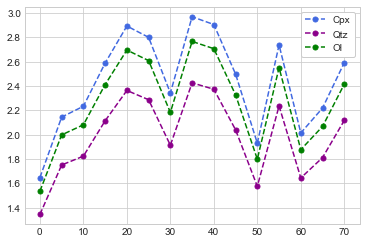

In [519]:
aug = [1.648311,2.145332,2.234211,2.589430,2.893831,2.800779,2.343775,2.970026,2.906030,2.498745,1.930763,2.738267,2.015022,2.219750,2.593097]
qtz = [1.345395,1.751556,1.824284,2.114955,2.364208,2.287938,1.913973,2.426741,2.374214,2.040776,1.576156,2.236746,1.645019,1.812447,2.117956]
ol = [1.536015,1.999047,2.081815,2.412659,2.696201,2.609557,2.183827,2.767112,2.707556,2.328168,1.799171,2.551330,1.877662,2.068349,2.416076]
plt.style.use('seaborn-whitegrid')

plt.plot(time, aug, 'o--', markersize = 5, color = 'royalblue', label = 'Cpx')
plt.plot(time, qtz, 'o--', markersize = 5, color = 'darkmagenta', label = 'Qtz')
plt.plot(time, ol, 'o--', markersize = 5, color = 'green', label = 'Ol')
plt.legend(frameon = True,facecolor='white',framealpha=1)

plt.savefig('sf_vs_time.png' , dpi = 300, bbox_inches = 'tight')



In [507]:
Siteprod_df

,0 - 50 kyr,50 kyr - 5 Ma,5 - 10 Ma,10 - 15 Ma,15 - 20 Ma,20 - 25 Ma,25 - 30 Ma,30 - 35 Ma,35 - 40 Ma,40 - 45 Ma,45 - 50 Ma,50 - 55 Ma,55 - 60 Ma,60 - 65 Ma,65 - 70 Ma
0,1.536015,1.999047,2.081815,2.412659,2.696201,2.609557,2.183827,2.767112,2.707556,2.328168,1.799171,2.551330,1.877662,2.068349,2.416076
1,2.080355,2.740653,2.862696,3.345730,3.763671,3.635648,3.013793,3.872457,3.781161,3.221566,2.447361,3.551288,2.564545,2.846703,3.356917
2,2.080355,2.740653,2.862696,3.345730,3.763671,3.635648,3.013793,3.872457,3.781161,3.221566,2.447361,3.551288,2.564545,2.846703,3.356917
3,2.080355,2.740653,2.862696,3.345730,3.763671,3.635648,3.013793,3.872457,3.781161,3.221566,2.447361,3.551288,2.564545,2.846703,3.356917
4,2.075984,2.734668,2.856390,3.338097,3.754949,3.627272,3.007083,3.863493,3.772388,3.214230,2.441977,3.543140,2.558972,2.840498,3.349354
5,3.226149,4.325637,4.538613,5.370117,6.102243,5.877689,4.803729,6.306074,6.133678,5.151244,3.811066,5.732907,4.022672,4.522281,5.408569
6,3.226149,4.325637,4.538613,5.370117,6.102243,5.877689,4.803729,6.306074,6.133678,5.151244,3.811066,5.732907,4.022672,4.522281,5.408569
7,1.848454,2.423760,2.529299,2.941066,3.302538,3.192676,2.659099,3.400728,3.317030,2.831164,2.156729,3.120288,2.267518,2.520504,2.959347
8,1.848454,2.423760,2.529299,2.941066,3.302538,3.192676,2.659099,3.400728,3.317030,2.831164,2.156729,3.120288,2.267518,2.520504,2.959347
9,3.807953,5.140344,5.402479,6.426057,7.329752,7.051911,5.729826,7.583982,7.369088,6.156781,4.513244,6.873779,4.770941,5.383600,6.475291


In [ ]:
plt.style.use('seaborn-whitegrid')

if system == 1: 
    plt.plot(time, SiteHe_qtz, 'o--', color = 'darkmagenta', label = 'Quartz')
    plt.errorbar(time[0],SiteHe_qtz[0], yerr=None, xerr = xerr2, ecolor = 'm' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_qtz[1::],yerr=None, xerr = 2.5, ecolor = 'm' ,ls = 'none')

if system == 2: 
    plt.plot(time,SiteHe_cpx,'o--', color = 'blue', label = 'Pyroxene')
    plt.errorbar(time[0],SiteHe_cpx[0], yerr=None, xerr = xerr2, ecolor = 'b' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_cpx[1::],yerr=None, xerr = 2.5, ecolor = 'b' ,ls = 'none')

if system == 3: 
    plt.plot(time,SiteHe_ol,'o--', color = 'green', label = 'Olivine')
    plt.errorbar(time[0],SiteHe_ol[0], yerr=None, xerr = xerr2, ecolor = 'g' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_ol[1::],yerr=None, xerr = 2.5, ecolor = 'g' ,ls = 'none')

plt.xlabel('Time [Ma]')
plt.ylabel('Scaling Factor')
plt.legend(frameon = True,facecolor='white',framealpha=1)

#plt.savefig('sf_vs_time.png' , dpi = 300, bbox_inches = 'tight')


In [554]:
scaling_factors_df = Siteprod_df
concentration_bin_0 = []
concentration_bin_1 = []
concentration_bin_2 = []
concentration_bin_3 = []
concentration_bin_4 = []
concentration_bin_5 = []
concentration_bin_6 = []
concentration_bin_7 = []
concentration_bin_8 = []
concentration_bin_9 = []
concentration_bin_10 = []
concentration_bin_11 = []
concentration_bin_12 = []
concentration_bin_13 = []
concentration_bin_14 = []
for i in range(len(sample_names)):
    concentration_bin_0.append(SLHL*scaling_factors_df.iloc[i,0]*50000) #SLHL*SF*len(bin_0)
    concentration_bin_1.append(SLHL*scaling_factors_df.iloc[i,1]*4950000)
    concentration_bin_2.append(SLHL*scaling_factors_df.iloc[i,2]*5000000)
    concentration_bin_3.append(SLHL*scaling_factors_df.iloc[i,3]*5000000)
    concentration_bin_4.append(SLHL*scaling_factors_df.iloc[i,4]*5000000)
    concentration_bin_5.append(SLHL*scaling_factors_df.iloc[i,5]*5000000)
    concentration_bin_6.append(SLHL*scaling_factors_df.iloc[i,6]*5000000)
    concentration_bin_7.append(SLHL*scaling_factors_df.iloc[i,7]*5000000)
    concentration_bin_8.append(SLHL*scaling_factors_df.iloc[i,8]*5000000)
    concentration_bin_9.append(SLHL*scaling_factors_df.iloc[i,9]*5000000)
    concentration_bin_10.append(SLHL*scaling_factors_df.iloc[i,10]*5000000)
    concentration_bin_11.append(SLHL*scaling_factors_df.iloc[i,11]*5000000)
    concentration_bin_12.append(SLHL*scaling_factors_df.iloc[i,12]*5000000)
    concentration_bin_13.append(SLHL*scaling_factors_df.iloc[i,13]*5000000)
    concentration_bin_14.append(SLHL*scaling_factors_df.iloc[i,14]*5000000)
    

In [555]:
exp_ages = []
for i in range(len(sample_names)):    
    x = nuclide_concentration[i] - concentration_bin_0[i]
    y = x/(SLHL*scaling_factors_df.iloc[i,1])
    exp_age = y + 50000
  
    if exp_age >= 5e6:
        x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i]
        y = x/(SLHL * scaling_factors_df.iloc[i,2]) 

        exp_age = y + 50000 + 4950000

        if exp_age >= 10e6:
            x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] - concentration_bin_2[i]
            y = x / (SLHL*scaling_factors_df.iloc[i,3])

            exp_age = y + 50000 + 4950000 + 5000000*(1)
            

            if exp_age >= 15e6:
                x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] - concentration_bin_2[i] - concentration_bin_3[i]
                y = x / (SLHL*scaling_factors_df.iloc[i,4])

                exp_age = y + 50000 + 4950000 + 5000000*(2)
            

                if exp_age >= 20e6:
                    x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] - concentration_bin_2[i] 
                    - concentration_bin_3[i] - concentration_bin_4[i]
                    y = x / (SLHL*scaling_factors_df.iloc[i,5])

                    exp_age = y + 50000 + 4950000 + 5000000*(3)
            

                    if exp_age >= 25e6:
                        x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                        - concentration_bin_2[i] - concentration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                        y = x / (SLHL*scaling_factors_df.iloc[i,6])

                        exp_age = y + 50000 + 4950000 + 5000000*(4)
            

                        if exp_age >= 30e6:
                            x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                            - concentration_bin_2[i] - concentration_bin_3[i]- concentration_bin_4[i] - concentration_bin_5[i]
                            y = x / (SLHL*scaling_factors_df.iloc[i,7])

                            exp_age = y + 50000 + 4950000 + 5000000*(5)
            

                            if exp_age >= 35e6:
                                x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i]
                                - concentration_bin_2[i] - concentration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                                - concentration_bin_6[i]
                                y = x / (SLHL*scaling_factors_df.iloc[i,8])

                                exp_age = y + 50000 + 4950000 + 5000000*(6)
            
                                if exp_age >= 40e6:
                                    x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                                    - concentration_bin_2[i] - concentration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                                    - concentration_bin_6[i] - concentration_bin_7[i]
                                    y = x / (SLHL*scaling_factors_df.iloc[i,9])

                                    exp_age = y + 50000 + 4950000 + 5000000*(7)
            

                                    if exp_age >= 45e6:
                                        x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                                        - concentration_bin_2[i] - concnetration_bin_3[i] - concentration_bin_4[i] 
                                        - concentration_bin_5[i]
                                        - concentration_bin_6[i] - concentration_bin_7[i]- concentration_bin_8[i]
                                        y = x / (SLHL*scaling_factors_df.iloc[i,10])

                                        exp_age = y + 50000 + 4950000 + 5000000*(8)
            

                                        if exp_age >= 50e6:
                                            x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] - concentration_bin_2[i] - concnetration_bin_3[i] 
                                            - concentration_bin_4[i] - concentration_bin_5[i]
                                            - concentration_bin_6[i] - concentration_bin_7[i]- concentration_bin_8[i]- concentration_bin_9[i]
                                            y = x / (SLHL*scaling_factors_df.iloc[i,11])

                                            exp_age = y + 50000 + 4950000 + 5000000*(9)
            

                                            if exp_age >= 55e6:
                                                x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                                                - concentration_bin_2[i] - concnetration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                                                - concentration_bin_6[i] - concentration_bin_7[i]- concentration_bin_8[i]- concentration_bin_9[i]
                                                -concentration_bin_10[i]
                                                y = x / (SLHL*scaling_factors_df.iloc[i,12])

                                                exp_age = y + 50000 + 4950000 + 5000000*(10)


                                                if exp_age >= 60e6:
                                                    x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                                                    - concentration_bin_2[i] - concnetration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                                                    - concentration_bin_6[i] - concentration_bin_7[i]- concentration_bin_8[i]- concentration_bin_9[i]
                                                    -concentration_bin_10[i] -concentration_bin_11[i]
                                                    y = x / (SLHL*scaling_factors_df.iloc[i,13])

                                                    exp_age = y + 50000 + 4950000 + 5000000*(11)


                                                    if exp_age >= 65e6:
                                                        x = (nuclide_concentration[i]) - concentration_bin_0[i] - concentration_bin_1[i] 
                                                        - concentration_bin_2[i] - concnetration_bin_3[i] - concentration_bin_4[i] - concentration_bin_5[i]
                                                        - concentration_bin_6[i] - concentration_bin_7[i]- concentration_bin_8[i]
                                                        - concentration_bin_9[i]-concentration_bin_10[i]-concentration_bin_11[i]
                                                        - concentration_bin_12[i]
                                                        y = x / (SLHL*scaling_factors_df.iloc[i,14])

                                                        exp_age = y + 50000 + 4950000 + 5000000*(12)

                                                        if exp_age > 70e6:
                                                            print('Error: does not extend beyond 70 Ma')
    exp_ages.append(exp_age)


In [556]:
exp_ages_df = pd.DataFrame(ll, columns = ['Exposure Age'])

## below is for testing purposes

In [406]:
t_model = [2504532.327524169, 2028302.456642925,2478230.22472139,4536203.084488231,2852431.270769867,4518564.8585691545,4128561.1285072127,
4372552.74174942, 5089940.815301882, 3282162.2717411555, 3622658.032310319, 3719785.2967789173, 3537132.6350937015, 10081680.708516465,
6823778.650414478, 10666847.402905505, 9374404.909257814, 9226158.745958406, 2228190.861735493, 2199321.411836009]

In [407]:
diff = []
for i in range(len(t_model)):
    difference = ll_df.iloc[i] - t_model[i]
    diff.append(difference)

In [524]:
tmodel = [2.580399e6, 2.129415e6, 2.601899e6, 4.763044e6, 2.994469e6, 4.874055e6, 4.453287e6, 4.557558e6,
5.296522e6, 3.575004e6 , 3.721100e6, 3.853220e6, 3.663996e6, 1.037463e7, 7.049367e6, 1.097669e7, 9.686674e6, 9.557236e6, 2.309861e6, 2.224096e6]

updated_tmodel = [2.580399, 2.129415, 2.601899, 4.763044, 2.994469, 4.874055, 4.453287, 4.557558,
5.296522, 3.575004 , 3.721100, 3.853220, 3.663996, 10.37463, 7.049367, 10.97669, 9.686674, 9.557236, 2.309861, 2.224096]

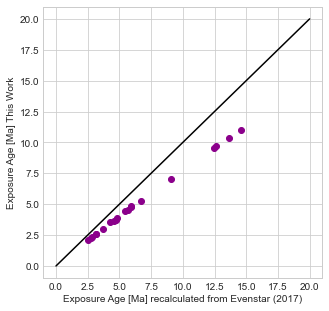

In [529]:
evenstar_He3 = [65.91, 74.48, 91.1, 167.12, 104.68, 269.89, 246.53, 141.41, 164.80, 235, 90.19, 107.8, 102.49, 298.96, 194.23, 310.26, 269.16, 277.15, 65.40, 41.29]
#SLHL = 119.3 #[at/g/yr]
texp = [3188863,2560853,3166922,5939087,3670960,5942367,5413382,5710884,6680445,4267817,4712387,4825234,4580202,13646406,9082561,14562636,
12643455,12447934,2823366,2784350]

multiplied_He3 = [element * 10**7 for element in evenstar_He3]
#multiplied_texp = [element*10**6 for element in texp]
updated_texp =[]
for i in range(len(texp)):
    updated = texp[i]/10**6
    updated_texp.append(updated)
    
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(updated_texp,updated_tmodel, 'o', c = 'darkmagenta')
plt.plot([0,20], [0,20], 'k-')
plt.xlabel('Exposure Age [Ma] recalculated from Evenstar (2017)', fontsize = 10)
plt.ylabel('Exposure Age [Ma] This Work', fontsize = 10)
plt.savefig('exposure_age.png', dpi = 300, bbox_inches='tight')
